In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_csv("BeerDataScienceProject.csv",encoding='latin-1') #read csv file
data.shape

(528870, 13)

In [3]:
data.head(2)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097


In [4]:
data['review_time'] = pd.to_datetime(data['review_time'],unit='s') #convert number into datetime

In [5]:
data['year'] = data['review_time'].dt.year #extract year from datetime column

In [6]:
data.head(2)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-16 20:57:03,2009
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01 13:44:57,2009


In [7]:
data.info() #check dataframe information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   beer_ABV            508590 non-null  float64       
 1   beer_beerId         528870 non-null  int64         
 2   beer_brewerId       528870 non-null  int64         
 3   beer_name           528870 non-null  object        
 4   beer_style          528870 non-null  object        
 5   review_appearance   528870 non-null  float64       
 6   review_palette      528870 non-null  float64       
 7   review_overall      528870 non-null  float64       
 8   review_taste        528870 non-null  float64       
 9   review_profileName  528755 non-null  object        
 10  review_aroma        528870 non-null  float64       
 11  review_text         528751 non-null  object        
 12  review_time         528870 non-null  datetime64[ns]
 13  year                528870 no

In [8]:
data['beer_beerId'].nunique() #find number of unique beer id

20200

In [9]:
#checking review count for each rating
print(data['beer_ABV'].min(),data['beer_ABV'].max())

0.01 57.7


In [10]:
data.isnull().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
year                      0
dtype: int64

In [11]:
data = data.dropna() #removing blank records

In [12]:
data['review_overall'].value_counts()

4.0    189623
4.5    107758
3.5     94478
3.0     50831
5.0     30279
2.5     17421
2.0     11168
1.5      3709
1.0      3088
0.0         3
Name: review_overall, dtype: int64

In [13]:
aggrAbvDf = data.groupby(['beer_brewerId','beer_beerId']).agg(ABV_Size=('beer_ABV', 'count'), ABV_Mean=('beer_ABV', np.mean))

In [14]:
aggrAbvDf.head()

ABV_Size  ABV_Mean
beer_brewerId beer_beerId                    
1             429              1256       4.4
              5916               46       5.0
              14348               6       5.0
              19099               4       4.2
              19123               7       4.1

In [15]:
beer_ABVmeanDf = aggrAbvDf.groupby(level='beer_brewerId').mean()
beer_ABVmeanDf.columns = ('mean_size', 'mean_beer_ABV')

In [16]:
beer_ABVmeanDf.head()

,mean_size,mean_beer_ABV
beer_brewerId,,
1,104.307692,4.876923
3,123.950000,6.237500
5,69.250000,4.837500
10,14.000000,4.625000
14,9.080645,6.588710


In [17]:
beer_ABVmeanDf.sort_values('mean_beer_ABV', ascending=False).reset_index().head(3) # display top 3 breweries produces strongest beer

,beer_brewerId,mean_size,mean_beer_ABV
0,6513,3.4,24.690000
1,736,6.0,13.500000
2,24215,1.0,12.466667


In [18]:
#finding year with highest rating
high_rating_df = data.groupby('year')['review_overall'].mean().rename('mean_overall_rating').reset_index().sort_values(by='mean_overall_rating', ascending=False)

In [19]:
high_rating_df.head()

,year,mean_overall_rating
2,2000,4.233333
0,1998,4.045455
1,1999,4.000000
3,2001,3.961896
12,2010,3.869430


Text(0, 0.5, 'average rating')

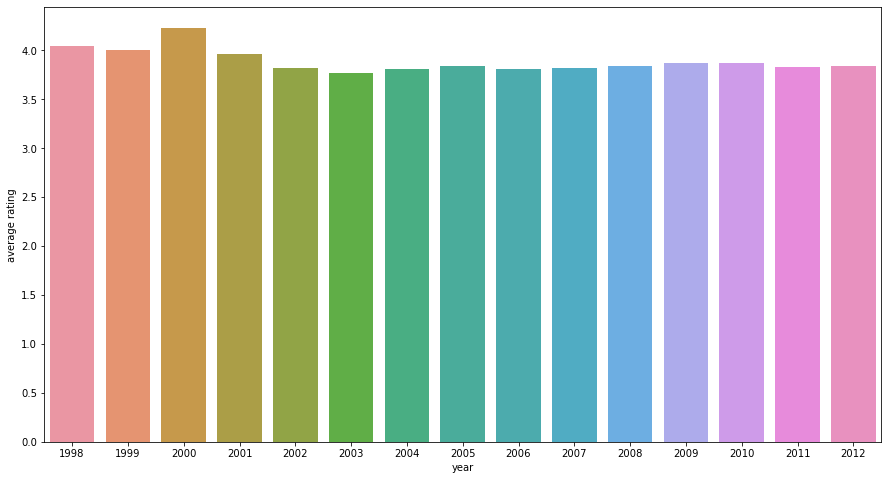

In [20]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=high_rating_df.year, y=high_rating_df.mean_overall_rating)
ax.set_xlabel("year")
ax.set_ylabel("average rating")

In [21]:
imp_factorDf = data.groupby(['beer_beerId']).agg(ABV_Size=('beer_beerId', np.size),
                                                      Appear_Mean=('review_appearance', np.mean), 
                                                      palette_Mean=('review_palette', np.mean), 
                                                      taste_Mean=('review_taste', np.mean),
                                                      Aroma_Mean=('review_aroma', np.mean),
                                                      overall_Mean=('review_overall', np.mean)).reset_index()

In [22]:
imp_factorDf.head()

,beer_beerId,ABV_Size,Appear_Mean,palette_Mean,taste_Mean,Aroma_Mean,overall_Mean
0,5,424,3.485849,3.205189,3.318396,3.340802,3.549528
1,6,877,3.836374,3.515964,3.513113,3.645382,3.706956
2,7,659,3.251138,3.179059,3.106980,3.101669,3.266313
3,8,68,3.294118,3.080882,3.301471,3.235294,3.647059
4,9,116,3.051724,2.853448,3.103448,3.043103,3.400862


<AxesSubplot:title={'center':"Pearson's Correlations Coeff"}>

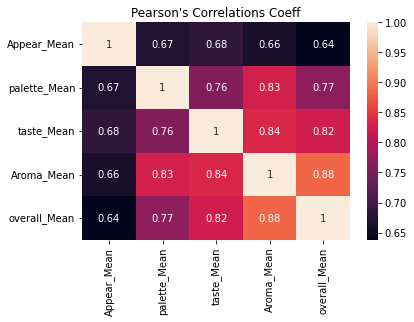

In [23]:
filter_df = imp_factorDf[['Appear_Mean','palette_Mean','taste_Mean','Aroma_Mean','overall_Mean']]
corr_df = filter_df.corr()
plt.title("Pearson's Correlations Coeff")
sns.heatmap(corr_df, 
        xticklabels=corr_df.columns,
        yticklabels=corr_df.columns,annot=True)

In [24]:
#looking at above correlation matrix, we can conclude that Aroma, taste, and palette are the three important factors as they are highl correlated with overall score

In [25]:
# Counting the number of the reviews and average of overall rating per beer id

data['review_count'] = data.groupby(['beer_beerId'])['review_overall'].transform('count')
data['review_mean'] = data.groupby(['beer_beerId'])['review_overall'].transform('mean')

In [26]:
data.head(2)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,review_count,review_mean
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-16 20:57:03,2009,1,1.5
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01 13:44:57,2009,1,3.0


In [27]:
data["Rank"] = data[["review_count","review_mean"]].apply(tuple,axis=1)\
             .rank(method='dense',ascending=False).astype(int) #apply rank basis on average rating and number of ratings

In [28]:
recommenddf = data[data["Rank"] <= 3] #selecting top 3 using rank
recommenddf = recommenddf[['beer_beerId','beer_name','review_count','review_mean','Rank']] #selecting reuired columns
recommenddf.sort_values(by='Rank', ascending=True,inplace=True)
recommenddf.drop_duplicates(keep='first') #removing duplicates

,beer_beerId,beer_name,review_count,review_mean,Rank
84839,1904,Sierra Nevada Celebration Ale,2998,4.168446,1
91265,276,Sierra Nevada Pale Ale,2586,4.245940,2
22138,11757,Founders Breakfast Stout,2501,4.354658,3


In [29]:
#looking at above table we can say that Sierra Nevada Celebration Ale,Sierra Nevada Pale Ale,and Founders Breakfast Stout have received highest number of ratings.Most of the people are recommending above 3 beers.

In [30]:
analyzer = SentimentIntensityAnalyzer()
data['compound'] = [analyzer.polarity_scores(x)['compound'] for x in data['review_text']] #finding out polarity score of each written review

In [31]:
data['review_overall'].value_counts()

4.0    189623
4.5    107758
3.5     94478
3.0     50831
5.0     30279
2.5     17421
2.0     11168
1.5      3709
1.0      3088
0.0         3
Name: review_overall, dtype: int64

In [32]:
data['score'] = np.where(data['review_overall']>= 4,'Promoters',
                        np.where((data['review_overall']>2) & (data['review_overall']<4),'Passives',
                                np.where(data['review_overall']<=2,'Detractors','Others')))  #classifying overall review in promoters, passives, detractors

In [33]:
data['score'].value_counts()

Promoters     327660
Passives      162730
Detractors     17968
Name: score, dtype: int64

In [34]:
print(data['compound'].min(),data['compound'].max())

-0.9969 0.9999


In [35]:
data['polarity_avg'] = data.groupby('beer_style')['compound'].transform('mean') #finding average polarity score by beer style

In [36]:
data.sort_values(by='polarity_avg',ascending=False).head(2)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,review_count,review_mean,Rank,compound,score,polarity_avg
342200,11.3,645,207,Trappistes Rochefort 10,Quadrupel (Quad),4.0,4.5,4.0,4.5,zoso493,4.5,Poured from a 330 ml bottle (is there another ...,2009-10-27 20:16:13,2009,2170,4.339401,8,0.9896,Promoters,0.857195
341394,11.3,645,207,Trappistes Rochefort 10,Quadrupel (Quad),4.5,4.5,4.0,4.0,Bourre,4.5,An amazing opaque brown color. The head quickl...,2004-03-25 23:31:17,2004,2170,4.339401,8,0.9676,Promoters,0.857195


In [37]:
print(data[data['polarity_avg']>=0.85]['beer_style'].value_counts(),data[data['polarity_avg']>=0.85].groupby('beer_style')['polarity_avg'].mean())  # looking at below data we can say that Quadrupel (Quad) is having highest average polarity score so this beer style is the most favorite among others considering written review

Quadrupel (Quad)             4822
Flanders Red Ale             2782
Dortmunder / Export Lager    1723
Braggot                       198
Roggenbier                    140
Name: beer_style, dtype: int64 beer_style
Braggot                      0.850845
Dortmunder / Export Lager    0.855512
Flanders Red Ale             0.850987
Quadrupel (Quad)             0.857195
Roggenbier                   0.852447
Name: polarity_avg, dtype: float64


In [38]:
data.groupby('review_overall')['compound'].mean().rename('avearge_polarity_sore').sort_values(ascending=False) #looking at below data we can say that there is a correlation between the overall review and written review

review_overall
5.0    0.894135
4.5    0.884584
4.0    0.832154
3.5    0.723241
3.0    0.584639
2.5    0.437646
2.0    0.301394
1.5    0.159372
1.0    0.012984
0.0   -0.638067
Name: avearge_polarity_sore, dtype: float64

In [61]:
similerDf = data.sort_values(by=['review_overall'],ascending=False)

In [62]:
similerDf.head(2)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,year,review_count,review_mean,Rank,compound,score,polarity_avg
492945,6.2,1339,132,Hazelnut Brown Nectar,American Brown Ale,4.5,3.0,5.0,4.5,prosper,5.0,"Served at ~15C. Gorgeous pour. Nut brown, slig...",2008-09-09 23:35:21,2008,1256,4.054538,50,0.9328,Promoters,0.772053
172728,4.7,689,221,Red Stripe Jamaican Lager,American Adjunct Lager,5.0,3.0,5.0,4.5,AussieInPhilly,4.0,"This beer is tops. The crisp, yet smooth taste...",2005-10-13 08:35:11,2005,894,3.370246,102,0.9054,Promoters,0.579283


In [63]:
similerDf['review_profileName'].nunique()

22563

In [64]:
similerDf.drop_duplicates(subset=['review_profileName'],keep='first',inplace=True)

In [68]:
similerDf1 = similerDf.groupby(['beer_name']).agg(average_polarity=('compound', 'mean'), unique_no_users=('review_profileName', 'nunique')).reset_index()

In [70]:
similerDf1.sort_values(by = 'unique_no_users', ascending=False) #looking at below we can conclude that people giving positive feedback and unber of users recommending smae beer

,beer_name,average_polarity,unique_no_users
2866,Tröegs Nugget Nectar,0.909621,451
1582,La Fin Du Monde,0.883453,339
982,Founders Breakfast Stout,0.897526,334
636,Chimay Grande Réserve (Blue),0.871512,283
2521,Sierra Nevada Pale Ale,0.834654,273
...,...,...,...
1396,Ichtegems Ale (Oud Bruin),0.944900,1
1390,I-beam Alt,0.994100,1
1389,Høst Bryg Kirsebær,0.605800,1
1388,Hyland's Sturbridge Farmhand Ale,0.989700,1
